In [1]:
import copy
import os
import time
import sqlalchemy
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from dotenv import load_dotenv

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel

from cities.modeling.zoning_models.zoning_tracts_continuous_interactions_model import TractsModelContinuousInteractions
from cities.utils.data_loader import select_from_data, ZoningDataset
from cities.modeling.waic import compute_waic


from cities.utils.data_grabber import find_repo_root

from cities.modeling.svi_inference import run_svi_inference
from cities.modeling.zoning_models.zoning_tracts_sqm_model import TractsModelSqm

from cities.utils.data_loader import select_from_sql


root = find_repo_root()


smoke_test = "CI" in os.environ
n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

In [2]:
# data loaded from pre-compiled data loader
# as direct db access won't be accessible 
# in CI or to curiuos users without credentials

census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path, weights_only=False)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))


#TODO add comments about variables

kwargs = {
    "categorical": ["year", "census_tract", 'university_index', 'downtown_index'],
    "continuous": {
        "housing_units",  
        "total_value",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        "segregation_original",
        "white_original",
        "parcel_sqm",
        'downtown_overlap', 
        'university_overlap',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

subset_for_preds = copy.deepcopy(subset)
vars_to_suspend = ["housing_units"]

for var in vars_to_suspend:
    subset_for_preds["continuous"][var] = None


Iterative discussions about the underlying causal structure, data availability and model improvements paired with performance evaluation led to the following baseline causal model. Once we inspect its performance, we will move on to one with pairwise interactions.

/home/rafal/miniconda3/envs/polis-dev/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


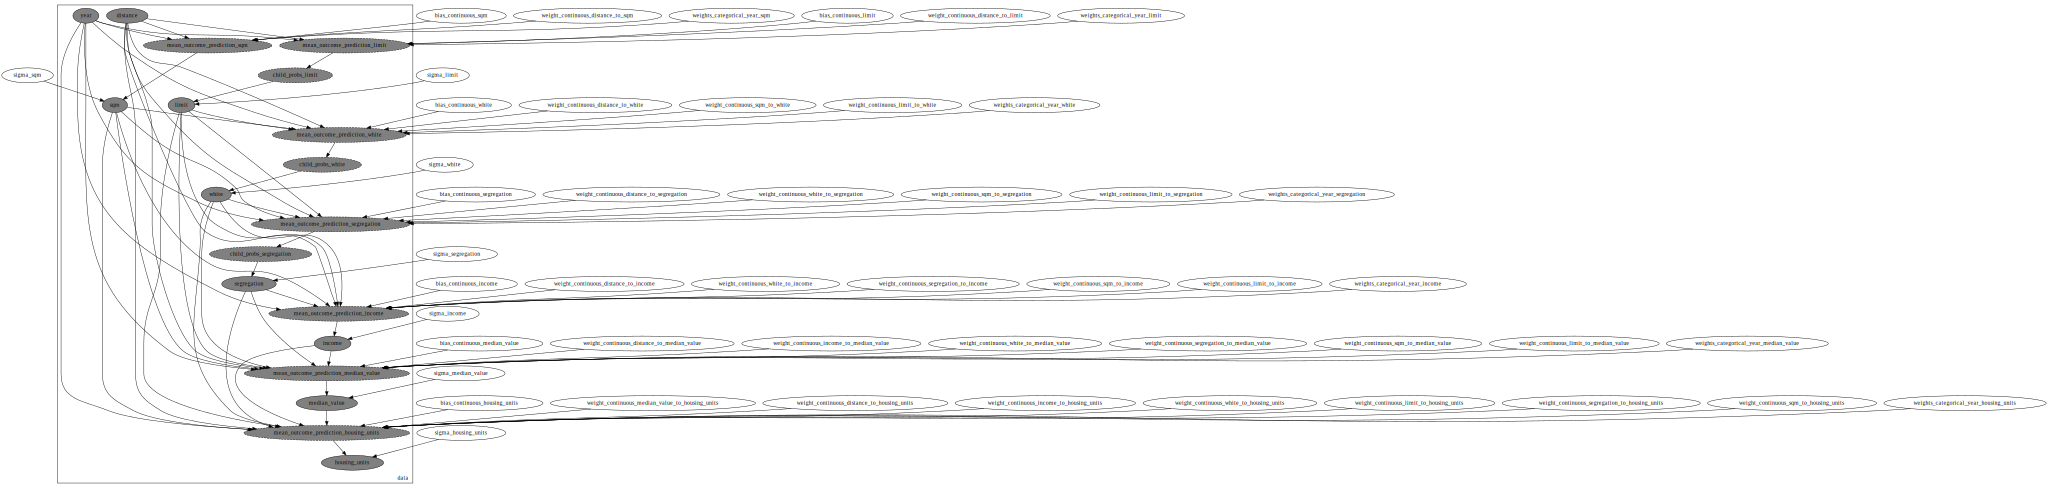

In [3]:
tracts_model = TractsModelSqm(
    **subset, categorical_levels=ct_dataset_read.categorical_levels
)

pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True, # this requires Pyro >= 1.9.1
    # visualization will be much less informative without rendering
    # the deterministic nodes, especially for model with interactions
)

Basic training-validate performance evaluation can be performed as follows:

In [4]:
# TODO uncomment with final run

# pyro.clear_param_store()

# train_loader, test_loader, categorical_levels = prep_data_for_test(
#     census_tracts_data_path, train_size=0.6
# )

# performance_results = test_performance(
#     tracts_model,
#     kwargs,
#     train_loader,
#     test_loader,
#     categorical_levels,
#     outcome_type="continuous",
#     outcome_name="housing_units",
#     n_steps=n_steps,
#     plot=True,
#     is_class=False,
# )

We can also compute mean absolute error improvement over the null model in the original scale of housing units per census tract.

In [ ]:
#TODO uncomment in final run

# def destandardize_housing_units(column):
#     mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
#     std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

#     return (column * std + mean).round()


# mae_improvement_train = destandardize_housing_units(
#     performance_results["mae_null_train"] - performance_results["mae_train"]
# )
# mae_improvement_test = destandardize_housing_units(
#     performance_results["mae_null_test"] - performance_results["mae_test"]
# )

# print(
#     f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
# )

In [7]:
# now we train the model with the full dataset
# cache the guide and the parameters

file_path = os.path.join(root, "data/minneapolis/guides", f"tracts_sqm_model_guide_pg.pkl")
param_path = os.path.join(
        root, "data/minneapolis/guides", "tracts_sqm_model_params_pg.pth"
    )

if not os.path.exists(file_path) or not os.path.exists(param_path):
    pyro.clear_param_store()
    sqm_guide = run_svi_inference(
        tracts_model,
        subset,
        n_steps=n_steps,
        num_samples=num_samples,
        smoke_test=smoke_test,
    )

    serialized_guide = dill.dumps(sqm_guide)
    with open(file_path, "wb") as file:
        file.write(serialized_guide)

    pyro.get_param_store().save(param_path)

else:
    pyro.clear_param_store()
    with open(file_path, "rb") as file:
        sqm_guide = dill.load(file)

    pyro.get_param_store().save(param_path)

We can now evaluate the train model by computing its Widely Acceptable Information Criterion score (WAIC):

In [10]:
waic_sqm = compute_waic(
    model=tracts_model,
    guide=sqm_guide,
    num_particles=10000,
    sites=["housing_units"],
    max_plate_nesting=9,
    **subset,
)

print(waic_sqm['waic'], waic_sqm['p_waic'])

tensor(2921.6980, grad_fn=<MulBackward0>) tensor(44.9544, grad_fn=<SumBackward0>)


In [14]:
# cache the predictions

sqm_preds_path = "sqm_preds.dill"

if not os.path.exists(sqm_preds_path):

    sqm_predictive = Predictive(tracts_model, guide=sqm_guide, num_samples=num_samples)

    sqm_preds = sqm_predictive(subset_for_preds)

    with open(sqm_preds_path, "wb") as f:
        dill.dump(sqm_preds, f)

else:
    with open(sqm_preds_path, "rb") as f:
        sqm_preds = dill.load(f)

The model's performance, however, is not great downtown and in the university area. Part of the reason is that the regulations for those areas were quite different and they were were not directly impacted by the parking reform. Let's inspect residuals.

(1130,) (1130,)


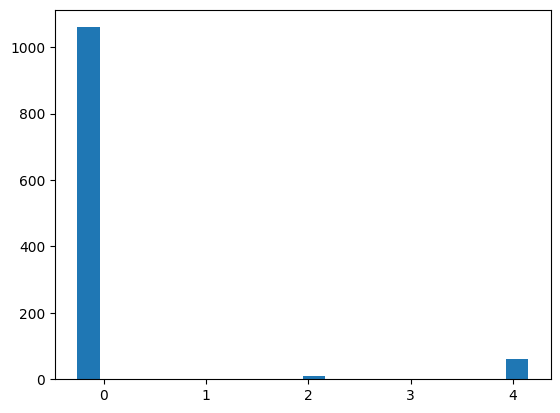

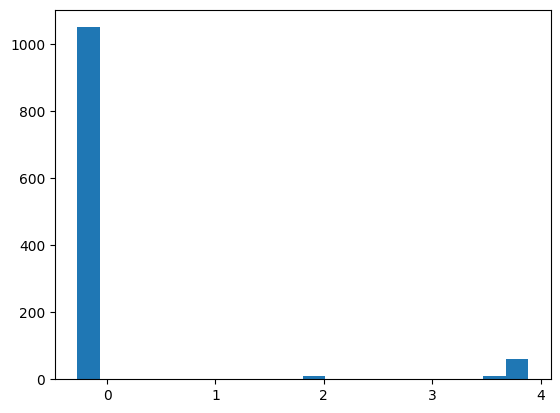

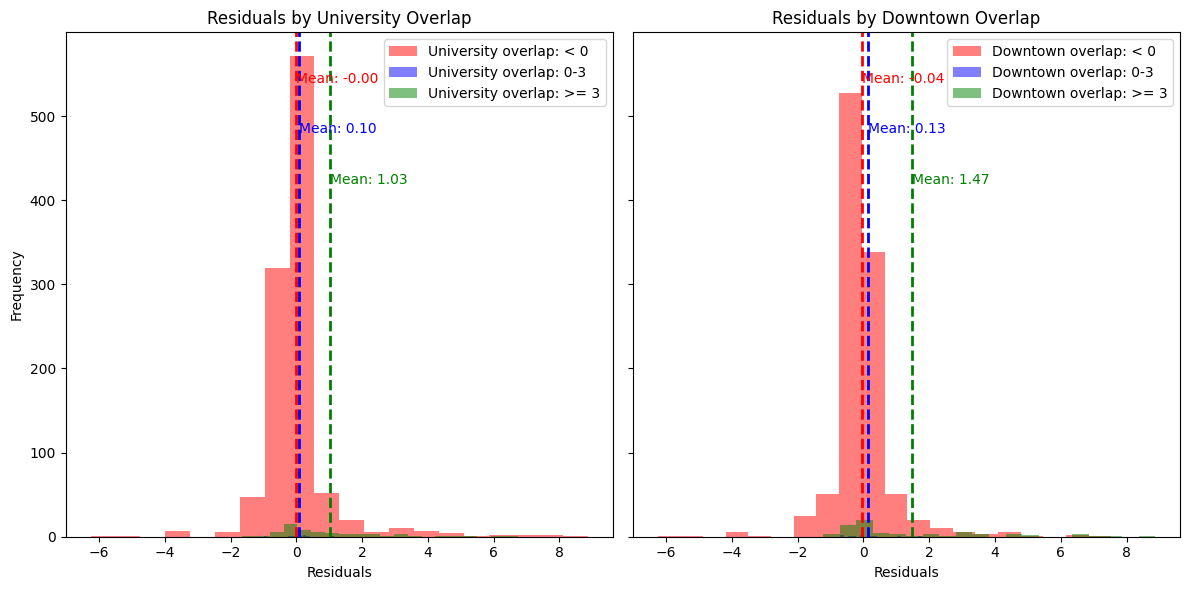

In [16]:
# first some data wrangling to get the residuals

university_overlap = subset['continuous']['university_overlap'].detach().numpy()
downtown_overlap = subset['continuous']['downtown_overlap'].detach().numpy()
units_observed = subset['continuous']['housing_units'].detach().numpy()

units_predicted = sqm_preds['housing_units'].mean(dim = 0).detach().numpy()

residuals = units_observed - units_predicted

print(units_observed.shape, units_predicted.shape)


# Note there are roughly three clusters for each of the overlap variables
plt.hist(university_overlap, bins = 20)
plt.show()

plt.hist(downtown_overlap, bins = 20)
plt.show()

bins = [-np.inf, 0, 3, np.inf]  # Representing university_overlap < 0, 
# 0 < university_overlap < 3, and university_overlap >= 3
bin_labels = ['< 0', '0-3', '>= 3']

university_bin_indices = np.digitize(university_overlap, bins=bins) - 1 
downtown_bin_indices = np.digitize(downtown_overlap, bins=bins) - 1

grouped_residuals_university = [residuals[university_bin_indices == i] for i in range(len(bins) - 1)]
grouped_residuals_downtown = [residuals[downtown_bin_indices == i] for i in range(len(bins) - 1)]


# now plot the residuals for each of the clusters

bins = [-np.inf, 0, 3, np.inf]  # Representing university_overlap < 0, 0 < university_overlap < 3, and university_overlap >= 3
bin_labels = ['< 0', '0-3', '>= 3']

residuals = units_observed - units_predicted

grouped_residuals_university = [residuals[university_bin_indices == i] for i in range(len(bins) - 1)]
grouped_residuals_downtown = [residuals[downtown_bin_indices == i] for i in range(len(bins) - 1)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

colors = ['red', 'blue', 'green']

y_offsets = [0.9, 0.8, 0.7]  # Adjust as needed

for i in range(len(bin_labels)):
    axes[0].hist(grouped_residuals_university[i], bins=20, alpha=0.5, label=f"University overlap: {bin_labels[i]}", color=colors[i])
    
    mean_university = np.mean(grouped_residuals_university[i])
    axes[0].axvline(mean_university, color=colors[i], linestyle='dashed', linewidth=2)
    
    y_position = axes[0].get_ylim()[1] * y_offsets[i]
    axes[0].text(mean_university, y_position, f'Mean: {mean_university:.2f}', color=colors[i])

axes[0].set_title("Residuals by University Overlap")
axes[0].set_xlabel("Residuals")
axes[0].set_ylabel("Frequency")
axes[0].legend()

for i in range(len(bin_labels)):
    axes[1].hist(grouped_residuals_downtown[i], bins=20, alpha=0.5, label=f"Downtown overlap: {bin_labels[i]}", color=colors[i])
    
    mean_downtown = np.mean(grouped_residuals_downtown[i])
    axes[1].axvline(mean_downtown, color=colors[i], linestyle='dashed', linewidth=2)
    
    y_position = axes[1].get_ylim()[1] * y_offsets[i]
    axes[1].text(mean_downtown, y_position, f'Mean: {mean_downtown:.2f}', color=colors[i])

axes[1].set_title("Residuals by Downtown Overlap")
axes[1].set_xlabel("Residuals")
axes[1].legend()

plt.tight_layout()
plt.show()


So we add two features: standardized ratio of downtown (university, respectively), overlap. Moreover, we considered adding pairwise interactions to the parents of `housing_units`. We proceeded as follows:

0. Start with adding all possible pairwise interactions. The resulting WAIC is around 4000, performance increases dramatically for the trainining set and drops to $R^2$ of around .18 on the validation set. We're clearly overfitting.
   
1. Start with a minimal plausible list that contains the overlap, distance and limit variables: 
   ```
   ins = [("university_overlap", "limit"),
    ("downtown_overlap", "limit"),
    ("distance", "downtown_overlap"),
    ("distance", "university_overlap"),
    ("distance", "limit"),]
    ```

2. Generate a list of all possible pairwise interactions, `list`. For each `l` in `list`, add `l` to `ins`, train the resulting model for 800 iterations, compute WAIC. From the resulting list of WAIC scores pick three lowest, add the corresponding pairs to interactions.

3. Train the resulting model for 2000 iterations, compute WAIC. If lower than the original WAIC score, and performance on the train-validation split doesn't decrease, keep.

Three iterations led to a situation with no further improvement, resulting in the following list of interactions:  

In [18]:
ins = [
    ("university_overlap", "limit"),
    ("downtown_overlap", "limit"),
    ("distance", "downtown_overlap"),
    ("distance", "university_overlap"),
    ("distance", "limit"),
    ('median_value', 'segregation'),
    ('distance', 'segregation'),
    ('limit', 'sqm'),
    ('segregation', 'sqm'),
    ('distance', 'white'),
    ('income', 'limit'),
    ('downtown_overlap', 'median_value'),
    ('downtown_overlap', 'segregation'),
    ('median_value', 'white'),
    ('distance', 'income'),
]

/home/rafal/miniconda3/envs/polis-dev/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


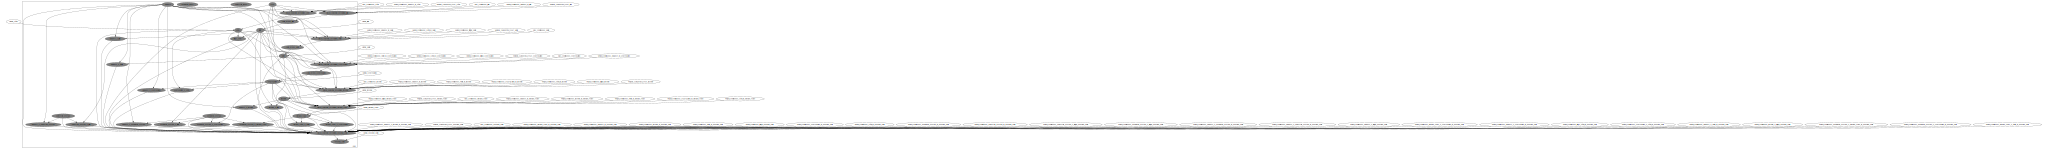

In [19]:
pyro.clear_param_store()

tracts_model = TractsModelContinuousInteractions(
    **subset,
    housing_units_continuous_interaction_pairs = ins
)

with pyro.poutine.trace() as tr:
    tracts_model(**subset)


assert tr.trace.nodes["housing_units"]["value"].shape == torch.Size([1130])

pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True,
)

In [ ]:
# evaluate performance, compute improvement in the original scale.
#TODO uncomment when final
# pyro.clear_param_store()


# train_loader, test_loader, categorical_levels = prep_data_for_test(
#     census_tracts_data_path, train_size=0.6
# )

# performance_results = test_performance(
#     tracts_model,
#     kwargs,
#     train_loader,
#     test_loader,
#     categorical_levels,
#     outcome_type="continuous",
#     outcome_name="housing_units",
#     n_steps=n_steps,
#     plot=True,
#     is_class=False,
# )

# mae_improvement_train = destandardize_housing_units(
#     performance_results["mae_null_train"] - performance_results["mae_train"]
# )
# mae_improvement_test = destandardize_housing_units(
#     performance_results["mae_null_test"] - performance_results["mae_test"]
# )

# print(
#     f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
# )

In [26]:
# cache guide and params
# now we train the model with the full dataset
# cache the guide and the parameters

file_path = os.path.join(root, "data/minneapolis/guides", f"tracts_interactions_model_guide_pg.pkl")
param_path = os.path.join(
        root, "data/minneapolis/guides", "tracts_interactions_model_params_pg.pth"
    )

if not os.path.exists(file_path) or not os.path.exists(param_path):
    print("training interactions")
    pyro.clear_param_store()
    interactions_guide = run_svi_inference(
        tracts_model,
        subset,
        n_steps=n_steps,
        num_samples=num_samples,
        smoke_test=smoke_test,
    )

    serialized_guide = dill.dumps(interactions_guide)
    with open(file_path, "wb") as file:
        file.write(serialized_guide)

    pyro.get_param_store().save(param_path)

else:
    print("loading")
    pyro.clear_param_store()
    with open(file_path, "rb") as file:
        interactions_guide = dill.load(file)
        

    pyro.get_param_store().save(param_path)

loading


In [27]:
waic_interaction = compute_waic(
    model=tracts_model,
    guide=interactions_guide,
    num_particles=10000,
    sites=["housing_units"],
    max_plate_nesting=9,
    **subset,
)

print(waic_interaction['waic'], waic_interaction['p_waic'])

tensor(2785.1616, grad_fn=<MulBackward0>) tensor(78.6472, grad_fn=<SumBackward0>)
